# Propensity Score Evaluation

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys


# Sklearn imports
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss

# LightGBM import
import lightgbm as lgb

# configure logging
import logging
# Clear all existing root handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure root logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# Optional: notebook-specific logger
logger = logging.getLogger("notebook")
logger.info("Notebook logger is active.")

# Add the DGP and utils modules to the path
sys.path.append('../dgps')
sys.path.append('../utils')
from dgp_01 import dgp_01
from ps_models import StackedEnsemble
from ps_evaluation import evaluate_and_rank_models, log_evaluation_report

# Set style for plots
plt.style.use('default')
sns.set_palette('husl')

# Set random seed for reproducibility
np.random.seed(42)

2025-07-11 09:47:27,498 - notebook - INFO - Notebook logger is active.


## Synthetic Data

Generate synthetic data to compare the performance of different propensity score estimation methods.


In [2]:
# Generate training dataset using the DGP
n_train = 1000
n_test = 1000
treatment_coef_std = 0.5
outcome_coef_std = 10.0

dgp_dict = {
    "n_covariates": 5,
    "treatment_assignment": "nonlinear",
    "outcome_assignment": "nonlinear",
    "treatment_effect": 2.0,
    "noise_std": 1.0,
    "treatment_coef_std": 0.5,
    "outcome_coef_std": 10.0,
}

# Generate training data with linear treatment assignment
train_data_linear = dgp_01(n=n_train, random_state=42, **dgp_dict)

logger.info(f"Training data shape: {train_data_linear.shape}")
logger.info(f"Training data columns: {list(train_data_linear.columns)}")

2025-07-11 09:47:27,525 - notebook - INFO - Training data shape: (1000, 8)
2025-07-11 09:47:27,530 - notebook - INFO - Training data columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'treatment', 'outcome', 'true_propensity_score']


### True Propensity Score Distribution

Visualize the distribution of true propensity scores on the test set.

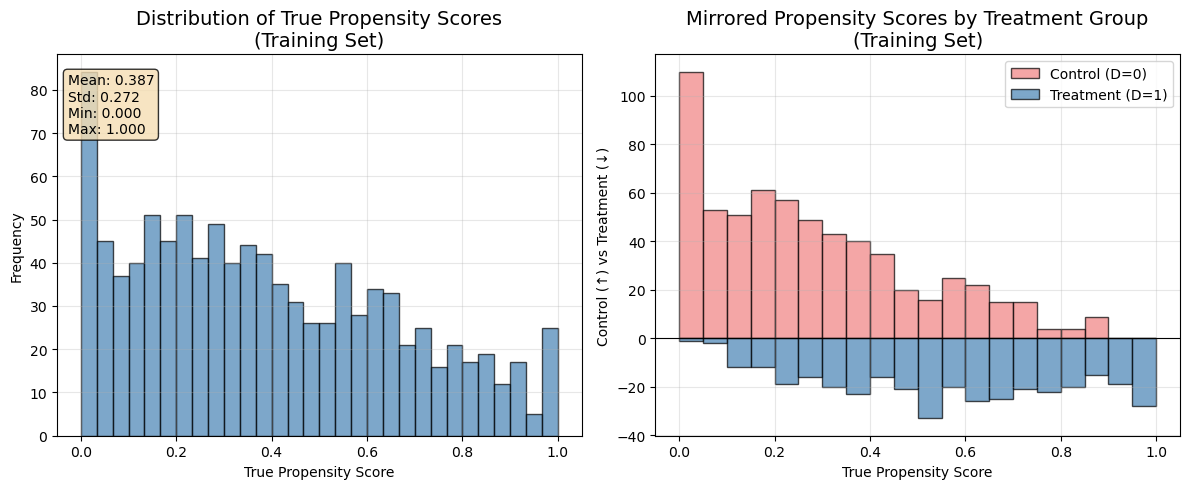

Training Set Summary:
  Total observations: 1000
  Treated: 371 (37.1%)
  Control: 629 (62.9%)
  Propensity Score - Mean: 0.387, Std: 0.272
  Propensity Score - Range: [0.000, 1.000]



In [3]:
def plot_propensity_distributions(data, title_prefix="", figsize=(12, 5)):
    """
    Plot propensity score distributions for a given dataset.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Dataset containing 'true_propensity_score' and 'treatment' columns
    title_prefix : str
        Prefix for plot titles (e.g., 'Training', 'Test', 'Validation')
    figsize : tuple
        Figure size for the plots
    """
    plt.figure(figsize=figsize)
    
    # Subplot 1: Histogram of propensity scores
    plt.subplot(1, 2, 1)
    plt.hist(data['true_propensity_score'], bins=30, alpha=0.7, 
             color='steelblue', edgecolor='black')
    plt.title(f'Distribution of True Propensity Scores\n({title_prefix} Set)', fontsize=14)
    plt.xlabel('True Propensity Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Add summary statistics as text
    ps_mean = data['true_propensity_score'].mean()
    ps_std = data['true_propensity_score'].std()
    ps_min = data['true_propensity_score'].min()
    ps_max = data['true_propensity_score'].max()
    
    plt.text(0.02, 0.95, f'Mean: {ps_mean:.3f}\nStd: {ps_std:.3f}\nMin: {ps_min:.3f}\nMax: {ps_max:.3f}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Subplot 2: Mirrored propensity scores by treatment group
    plt.subplot(1, 2, 2)
    treated = data[data['treatment'] == 1]['true_propensity_score']
    control = data[data['treatment'] == 0]['true_propensity_score']
    
    # Create histogram data
    bins = np.linspace(0, 1, 21)
    control_counts, _ = np.histogram(control, bins=bins)
    treated_counts, _ = np.histogram(treated, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot mirrored histograms
    plt.bar(bin_centers, control_counts, width=bins[1]-bins[0], alpha=0.7,
            color='lightcoral', edgecolor='black', label='Control (D=0)')
    plt.bar(bin_centers, -treated_counts, width=bins[1]-bins[0], alpha=0.7,
            color='steelblue', edgecolor='black', label='Treatment (D=1)')
    
    plt.title(f'Mirrored Propensity Scores by Treatment Group\n({title_prefix} Set)', fontsize=14)
    plt.xlabel('True Propensity Score')
    plt.ylabel('Control (↑) vs Treatment (↓)')
    plt.axhline(y=0, color='black', linewidth=0.8)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    n_total = len(data)
    n_treated = len(treated)
    n_control = len(control)
    treatment_rate = n_treated / n_total
    
    print(f"{title_prefix} Set Summary:")
    print(f"  Total observations: {n_total}")
    print(f"  Treated: {n_treated} ({treatment_rate:.1%})")
    print(f"  Control: {n_control} ({1-treatment_rate:.1%})")
    print(f"  Propensity Score - Mean: {ps_mean:.3f}, Std: {ps_std:.3f}")
    print(f"  Propensity Score - Range: [{ps_min:.3f}, {ps_max:.3f}]")
    print()

plot_propensity_distributions(train_data_linear, "Training")

## Propensity Scores

We will use a robust ensemble pipeline that combines multiple learners:

### Cross-fitted Propensity Scores

In [4]:
base_learners = {
    # Tree-based models
    'lgbm': lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    ),
    'rf': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    
    # Linear models
    'lr': LogisticRegression(
        C=1.0,
        penalty='l2',
        random_state=42,
        max_iter=1000
    ),
    'lr_l1': LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='liblinear',
        random_state=42,
        max_iter=1000
    ),
}

Create and stacked learner and fit all models

In [5]:
# Create ensemble with robust scaler and logistic regression meta-learner
ensemble_model = StackedEnsemble(
    base_learners=base_learners,
    scaler=RobustScaler(),
    stacking_learner=LogisticRegression(random_state=42),
    n_folds_stacking=5
)

2025-07-11 09:47:27,778 - ps_models - INFO - StackedEnsemble initialized with 4 base learners: ['lgbm', 'rf', 'lr', 'lr_l1']
2025-07-11 09:47:27,779 - ps_models - INFO - Scaler: RobustScaler
2025-07-11 09:47:27,779 - ps_models - INFO - Stacking learner: LogisticRegression


Generate cross-fitted predictions for propensity scores.

In [6]:
ps_dict = ensemble_model.predict_ps(
    X=train_data_linear.drop(columns=['treatment', 'true_propensity_score']),
    y=train_data_linear['treatment']
)

2025-07-11 09:47:27,785 - ps_models - INFO - Generating propensity scores for 1000 samples using 5-fold CV
2025-07-11 09:47:34,289 - ps_models - INFO - Propensity score predictions completed for 10 models


### Predictive Performance Evaluation

In [7]:
results_df, ranking_df, summary_stats = evaluate_and_rank_models(
    y_true= train_data_linear['treatment'],
    prob_dict=ps_dict,
    true_ps=train_data_linear['true_propensity_score'],
    threshold=0.5,
    n_bins=10,
)

log_evaluation_report(
    results_df=results_df,
    ranking_df=ranking_df,
    summary_stats=summary_stats,
)

2025-07-11 09:47:34,355 - ps_evaluation - INFO - ================================================================================
2025-07-11 09:47:34,356 - ps_evaluation - INFO - PROPENSITY SCORE MODEL EVALUATION REPORT
2025-07-11 09:47:34,356 - ps_evaluation - INFO - ================================================================================
2025-07-11 09:47:34,356 - ps_evaluation - INFO - Dataset Summary:
2025-07-11 09:47:34,357 - ps_evaluation - INFO -   Dataset_Size: 1000
2025-07-11 09:47:34,357 - ps_evaluation - INFO -   Treatment_Rate: 0.3710
2025-07-11 09:47:34,357 - ps_evaluation - INFO -   Control_Rate: 0.6290
2025-07-11 09:47:34,357 - ps_evaluation - INFO -   N_Treated: 371
2025-07-11 09:47:34,358 - ps_evaluation - INFO -   N_Control: 629
2025-07-11 09:47:34,358 - ps_evaluation - INFO -   True_PS_Mean: 0.3874
2025-07-11 09:47:34,358 - ps_evaluation - INFO -   True_PS_Std: 0.2723
2025-07-11 09:47:34,358 - ps_evaluation - INFO -   True_PS_Min: 0.0000
2025-07-11 09:47:34,35

### Calibration Analysis

Calibration plots show how well the predicted propensity scores match the actual treatment assignment rates. A well-calibrated model should have predicted probabilities that closely match the observed frequencies.

In [8]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_calibration_curves(y_true, prob_dict, n_bins=10, figsize=(15, 10)):
    """
    Plot calibration curves for multiple models.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels (0 or 1)
    prob_dict : dict
        Dictionary with model names as keys and predicted probabilities as values
    n_bins : int
        Number of bins for calibration curve
    figsize : tuple
        Figure size
    """
    n_models = len(prob_dict)
    cols = 3
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Colors for different models
    colors = ['steelblue', 'darkgreen', 'darkred', 'purple', 'orange']
    
    # Create individual calibration plots
    for idx, (model_name, y_prob) in enumerate(prob_dict.items()):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        # Calculate calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=n_bins, strategy='uniform'
        )
        
        # Calculate Brier score
        brier_score = brier_score_loss(y_true, y_prob)
        
        # Plot calibration curve
        ax.plot(mean_predicted_value, fraction_of_positives, 's-', 
                color=colors[idx % len(colors)], linewidth=2, markersize=8,
                label=f'{model_name} (Brier: {brier_score:.3f})')
        
        # Plot perfect calibration line
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Perfect calibration')
        
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title(f'Calibration Plot: {model_name.upper()}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    # Hide extra subplots
    for idx in range(n_models, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Create combined calibration plot
    plt.figure(figsize=(10, 8))
    
    for idx, (model_name, y_prob) in enumerate(prob_dict.items()):
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=n_bins, strategy='uniform'
        )
        brier_score = brier_score_loss(y_true, y_prob)
        
        plt.plot(mean_predicted_value, fraction_of_positives, 's-', 
                 color=colors[idx % len(colors)], linewidth=2, markersize=8,
                 label=f'{model_name} (Brier: {brier_score:.3f})')
    
    # Plot perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=2, label='Perfect calibration')
    
    plt.xlabel('Mean Predicted Probability', fontsize=14)
    plt.ylabel('Fraction of Positives', fontsize=14)
    plt.title('Calibration Curves Comparison (Training Data)', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

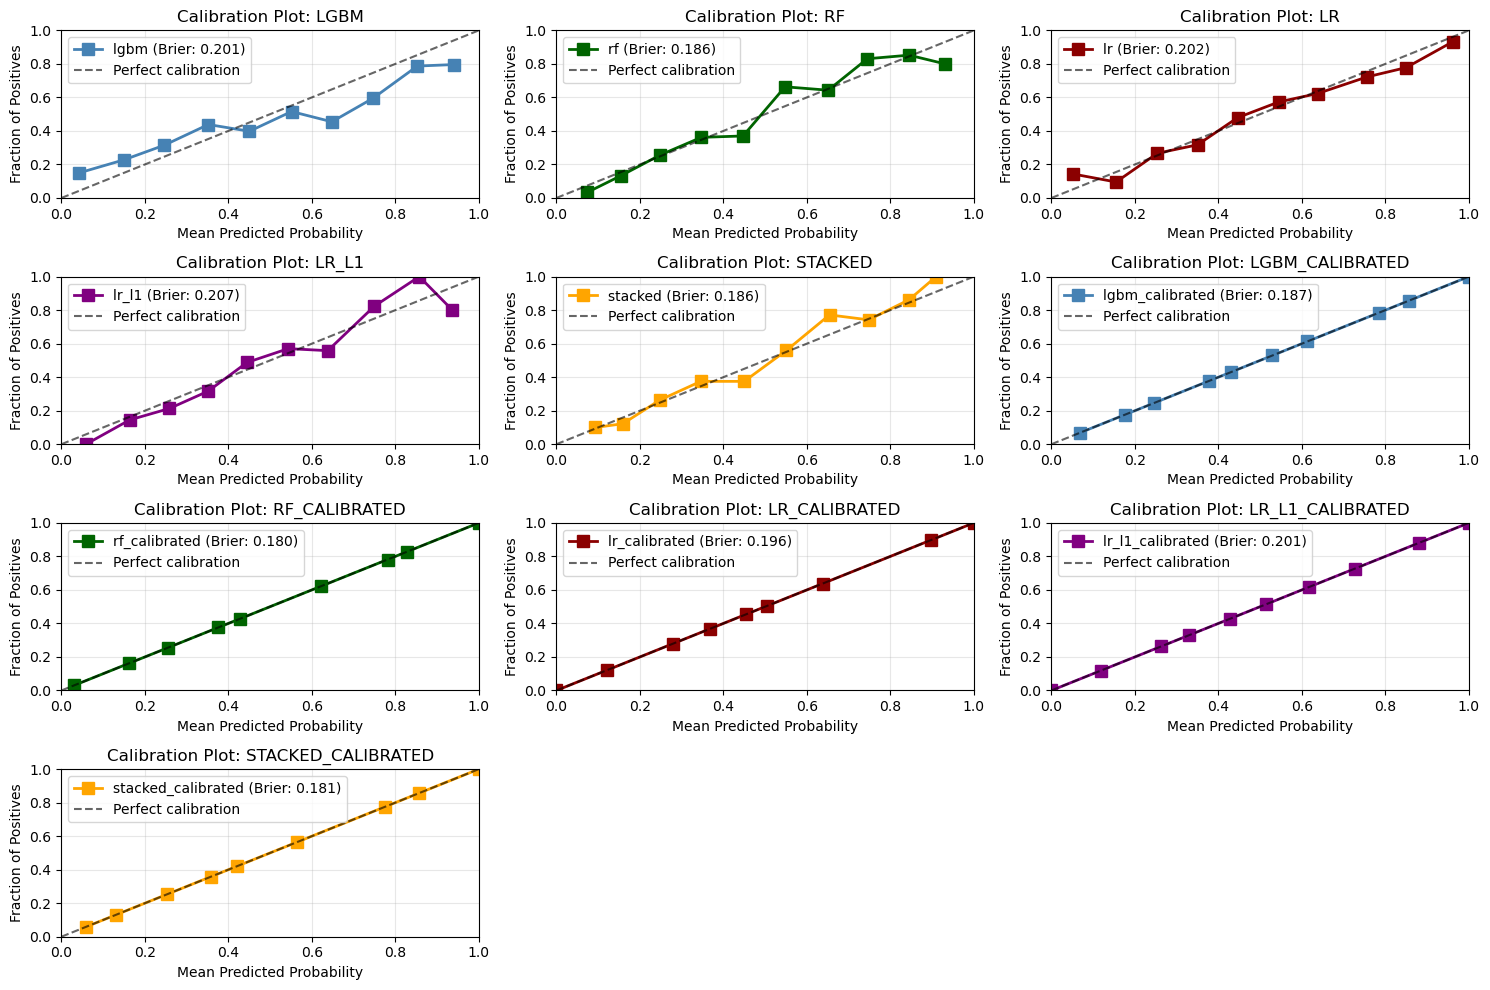

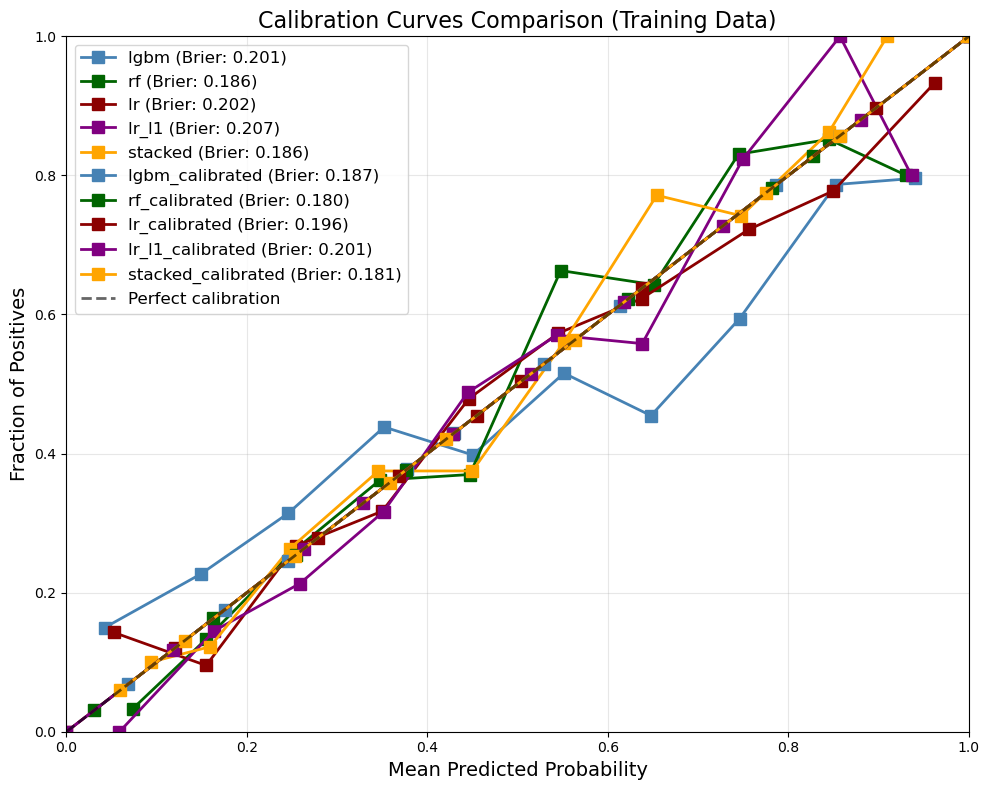

In [10]:
# Create calibration plots for training data
plot_calibration_curves(
    y_true=train_data_linear['treatment'],
    prob_dict=ps_dict,
    n_bins=10
)

### Oracle Evaluation

Let's compare how well each model (base and calibrated) predicts the true propensity scores.

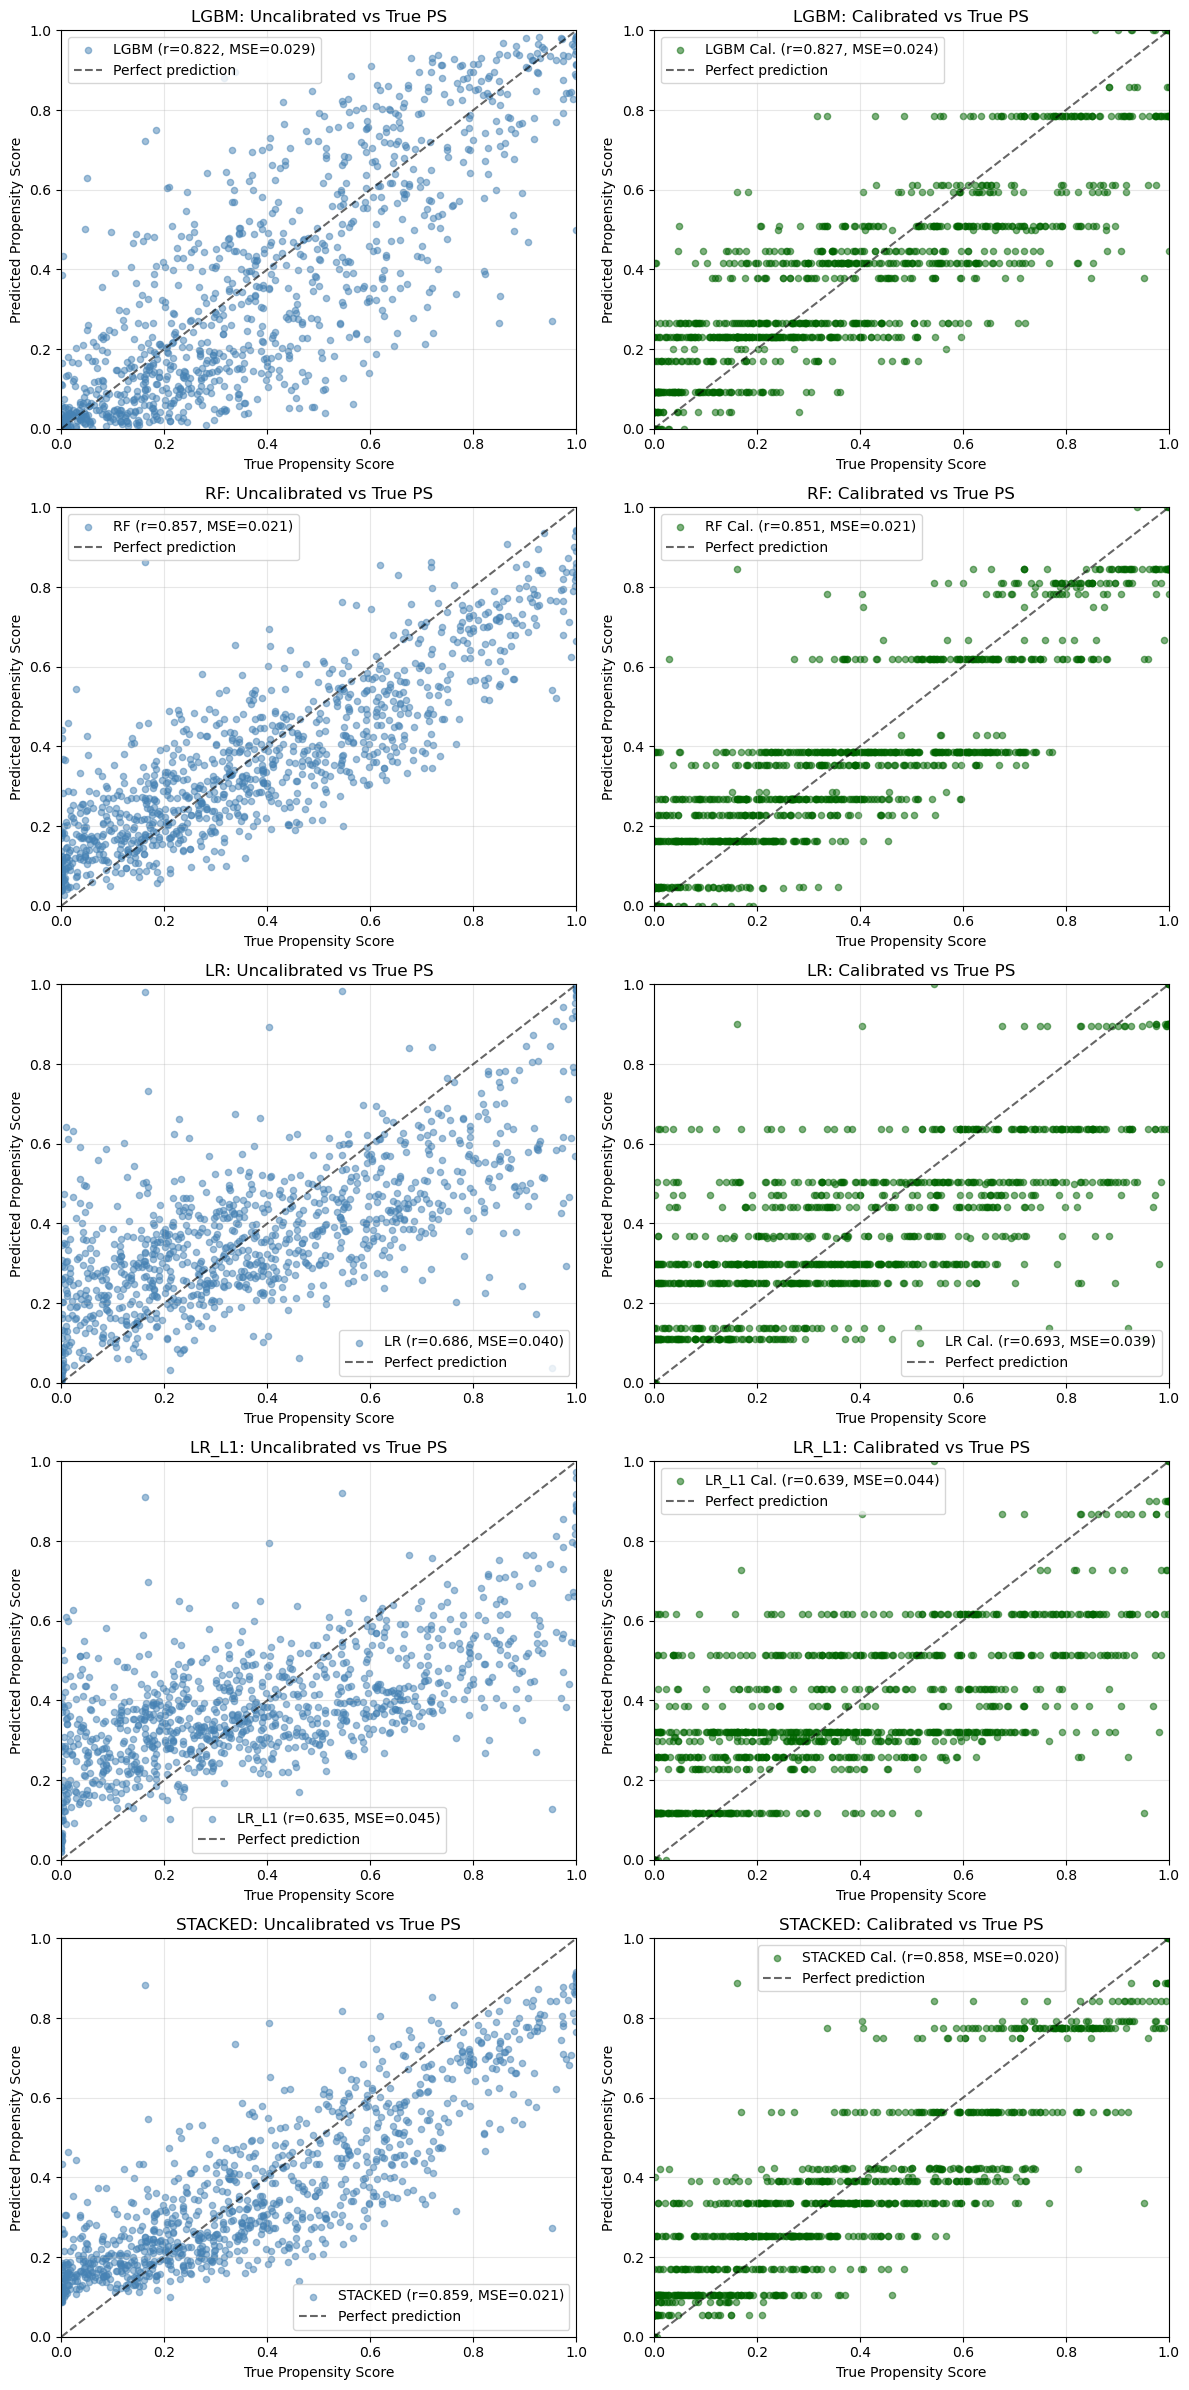

In [11]:
def plot_vs_true_propensity_comparison(true_ps, prob_dict, figsize=(12, 24)):
    """
    Plot predicted vs true propensity scores for base models and their calibrated versions.
    Left column: uncalibrated models, Right column: calibrated models
    
    Parameters:
    -----------
    true_ps : array-like
        True propensity scores
    prob_dict : dict
        Dictionary with model names as keys and predicted probabilities as values
    figsize : tuple
        Figure size
    """
    from scipy.stats import pearsonr
    from sklearn.metrics import mean_squared_error
    
    # Find base models and their calibrated versions
    base_models = {k: v for k, v in prob_dict.items() if not k.endswith('_calibrated')}
    
    # Filter to only include base models that have calibrated versions
    valid_base_models = {}
    for base_name, base_probs in base_models.items():
        calibrated_name = f"{base_name}_calibrated"
        if calibrated_name in prob_dict:
            valid_base_models[base_name] = base_probs
    
    if not valid_base_models:
        print("No valid base-calibrated model pairs found!")
        return
    
    # Create figure with subplots - 2 columns per model (uncalibrated, calibrated)
    n_models = len(valid_base_models)
    rows = n_models
    cols = 2
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Colors for base and calibrated models
    base_color = 'steelblue'
    calibrated_color = 'darkgreen'
    
    for idx, (base_name, base_probs) in enumerate(valid_base_models.items()):

        # Get calibrated version (we know it exists)
        calibrated_name = f"{base_name}_calibrated"
        calibrated_probs = prob_dict[calibrated_name]
        
        # Calculate correlations and MSE
        base_corr, _ = pearsonr(true_ps, base_probs)
        base_mse = mean_squared_error(true_ps, base_probs)
        
        cal_corr, _ = pearsonr(true_ps, calibrated_probs)
        cal_mse = mean_squared_error(true_ps, calibrated_probs)
        
        # Left column: Uncalibrated model
        ax_left = axes[idx, 0]
        ax_left.scatter(true_ps, base_probs, alpha=0.5, color=base_color, s=20,
                  label=f'{base_name.upper()} (r={base_corr:.3f}, MSE={base_mse:.3f})')
        ax_left.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Perfect prediction')
        ax_left.set_xlabel('True Propensity Score')
        ax_left.set_ylabel('Predicted Propensity Score')
        ax_left.set_title(f'{base_name.upper()}: Uncalibrated vs True PS')
        ax_left.legend()
        ax_left.grid(True, alpha=0.3)
        ax_left.set_xlim(0, 1)
        ax_left.set_ylim(0, 1)
        
        # Right column: Calibrated model
        ax_right = axes[idx, 1]
        ax_right.scatter(true_ps, calibrated_probs, alpha=0.5, color=calibrated_color, s=20,
                       label=f'{base_name.upper()} Cal. (r={cal_corr:.3f}, MSE={cal_mse:.3f})')
        ax_right.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Perfect prediction')
        ax_right.set_xlabel('True Propensity Score')
        ax_right.set_ylabel('Predicted Propensity Score')
        ax_right.set_title(f'{base_name.upper()}: Calibrated vs True PS')
        ax_right.legend()
        ax_right.grid(True, alpha=0.3)
        ax_right.set_xlim(0, 1)
        ax_right.set_ylim(0, 1)
    
    
    plt.tight_layout()
    plt.show()

# Create comparison plots vs true propensity scores
plot_vs_true_propensity_comparison(
    true_ps=train_data_linear['true_propensity_score'],
    prob_dict=ps_dict
)

## IPW & Matching Analysis